In [1]:
# import numpy as np

# # !/usr/bin/env python3
# # -*- coding: utf-8 -*-
# """
# Created on 20181219

# @author: zhangji

# Trajection of a ellipse, Jeffery equation. 
# """

# %pylab inline
# pylab.rcParams['figure.figsize'] = (25, 11)
# fontsize = 40

# import numpy as np
# import scipy as sp
# from scipy.optimize import leastsq, curve_fit
# from scipy import interpolate
# from scipy.interpolate import interp1d
# from scipy.io import loadmat, savemat
# # import scipy.misc

# import matplotlib
# from matplotlib import pyplot as plt
# from matplotlib import animation, rc
# import matplotlib.ticker as mtick
# from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
# from mpl_toolkits.mplot3d import Axes3D, axes3d

# from sympy import symbols, simplify, series, exp
# from sympy.matrices import Matrix
# from sympy.solvers import solve

# from IPython.display import display, HTML
# from tqdm import tqdm_notebook as tqdm
# import pandas as pd
# import re
# from scanf import scanf
# import os
# import glob

# from codeStore import support_fun as spf
# from src.support_class import *
# from src import stokes_flow as sf

# rc('animation', html='html5')
# PWD = os.getcwd()
# font = {'size': 20}
# matplotlib.rc('font', **font)
# np.set_printoptions(linewidth=90, precision=5)

%load_ext autoreload
%autoreload 2

from tqdm import tqdm_notebook
import os
import glob
import natsort 
import numpy as np
import scipy as sp
from scipy.optimize import leastsq, curve_fit
from scipy import interpolate, integrate
from scipy import spatial, signal
# from scipy.interpolate import interp1d
from scipy.io import loadmat, savemat
# import scipy.misc
from IPython.display import display, HTML
import pandas as pd
import pickle
import re
from scanf import scanf

import matplotlib
# matplotlib.use('agg')
from matplotlib import pyplot as plt
import matplotlib.colors as colors
from matplotlib import animation, rc
import matplotlib.ticker as mtick
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
from mpl_toolkits.mplot3d import Axes3D, axes3d
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from matplotlib import cm

from tqdm.notebook import tqdm as tqdm_notebook
from tqdm import tqdm
from time import time
from src.support_class import *
from src import jeffery_model as jm
from codeStore import support_fun as spf
from codeStore import support_fun_table as spf_tb

# %matplotlib notebook
%matplotlib inline
rc('animation', html='html5')
fontsize = 40
PWD = os.getcwd()

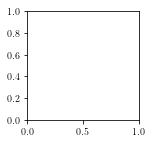

In [2]:
fig = plt.figure(figsize=(2, 2))
fig.patch.set_facecolor('white')
ax0 = fig.add_subplot(1, 1, 1)

In [3]:
job_dir = 'ecoC01B05_wt2_psi_rada'

t_headle = '(.*?).pickle'

In [ ]:
n_load = 10000
rand_mode=False

t_dir = os.path.join(PWD, job_dir)
_ = spf_tb.load_rand_data_pickle_dir_v2(t_dir, t_headle, n_load=n_load, rand_mode=rand_mode)
ini_theta_list, ini_phi_list, ini_psi_list, std_eta_list, psi_max_phi_list, \
theta_autocorrelate_fre_list, phi_autocorrelate_fre_list, psi_autocorrelate_fre_list, \
eta_autocorrelate_fre_list, dx_list, dy_list, dz_list, pickle_path_list = _

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [13]:
t_name = os.path.join(os.getcwd(), 'ecoC01B05_phase_Peclet', '%s.pickle' % job_dir)
with open(t_name, 'wb') as handle:    
    pickle.dump(_, handle, protocol=pickle.HIGHEST_PROTOCOL)
print('save to %s' % t_name)

save to /home/zhangji/stokes_flow_master/head_Force/do_calculate_table/ecoC01B05_phase_Peclet/ecoC01B05_wt2_psi_rada.pickle


[[   0    1    2    3    4    5    6]
 [   1    3   16 5422    1 4556    1]]

0 1 0.5998245822768867 0.24769843748511006
1 3 0.9926227364755436 9.14155923286907e-11
2 16 0.031158871945479675 0.03631509635164466
3 5422 0.9926227364732761 1.4577154060180888e-13
4 1 0.9926227364732547 3.771139484754897e-14
5 4556 0.9926227364732769 4.1289252464434855e-14
6 1 0.9926227364732577 2.6616856625075858e-14


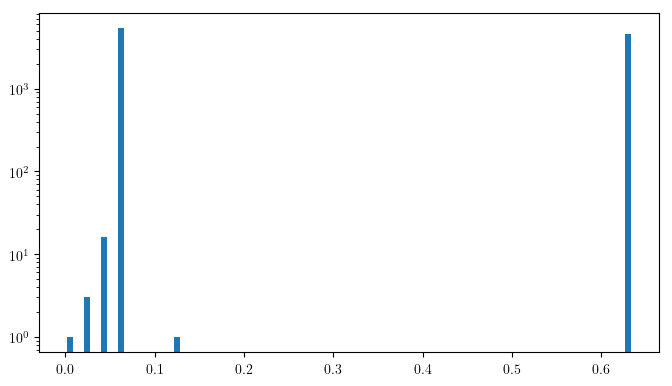

In [6]:
n_hist = 100
figsize = np.array((16, 9)) * 0.5
dpi = 100
# use_autocorrelate_fre_list = theta_autocorrelate_fre_list
# use_autocorrelate_fre_list = phi_autocorrelate_fre_list
use_autocorrelate_fre_list = eta_autocorrelate_fre_list

tmax_fre_list = np.hstack([t1[0, 0] for t1 in use_autocorrelate_fre_list])
# tmax_fre_list = tmax_fre_list[tmax_fre_list < 0.04]
fig, axi = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
t1 = axi.hist(tmax_fre_list, n_hist)
axi.set_yscale('log')

bin_edges = np.histogram_bin_edges(tmax_fre_list, n_hist)
case_idx0 = np.digitize(tmax_fre_list, bin_edges)
case_idx = np.ones_like(case_idx0) * -1
for i1, i0 in enumerate(np.unique(case_idx0)):
    tidx = np.isclose(case_idx0, i0)
    case_idx[tidx] = i1
assert np.all(case_idx >= 0)
print(np.vstack((np.unique(case_idx), np.bincount(case_idx))))
print()

for use_case, n_case in zip(np.unique(case_idx), np.bincount(case_idx)):
    tidx = np.isclose(case_idx, use_case)
    # np.mean(psi_max_phi_list[tidx][psi_max_phi_list[tidx] > np.pi])
    print(use_case, n_case, np.mean(std_eta_list[tidx][:, 0] / np.pi), (std_eta_list[tidx][:, 1] / np.pi).max())

/anaconda3/envs/py35/lib/python3.5/site-packages/matplotlib/tight_layout.py:199: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '


True

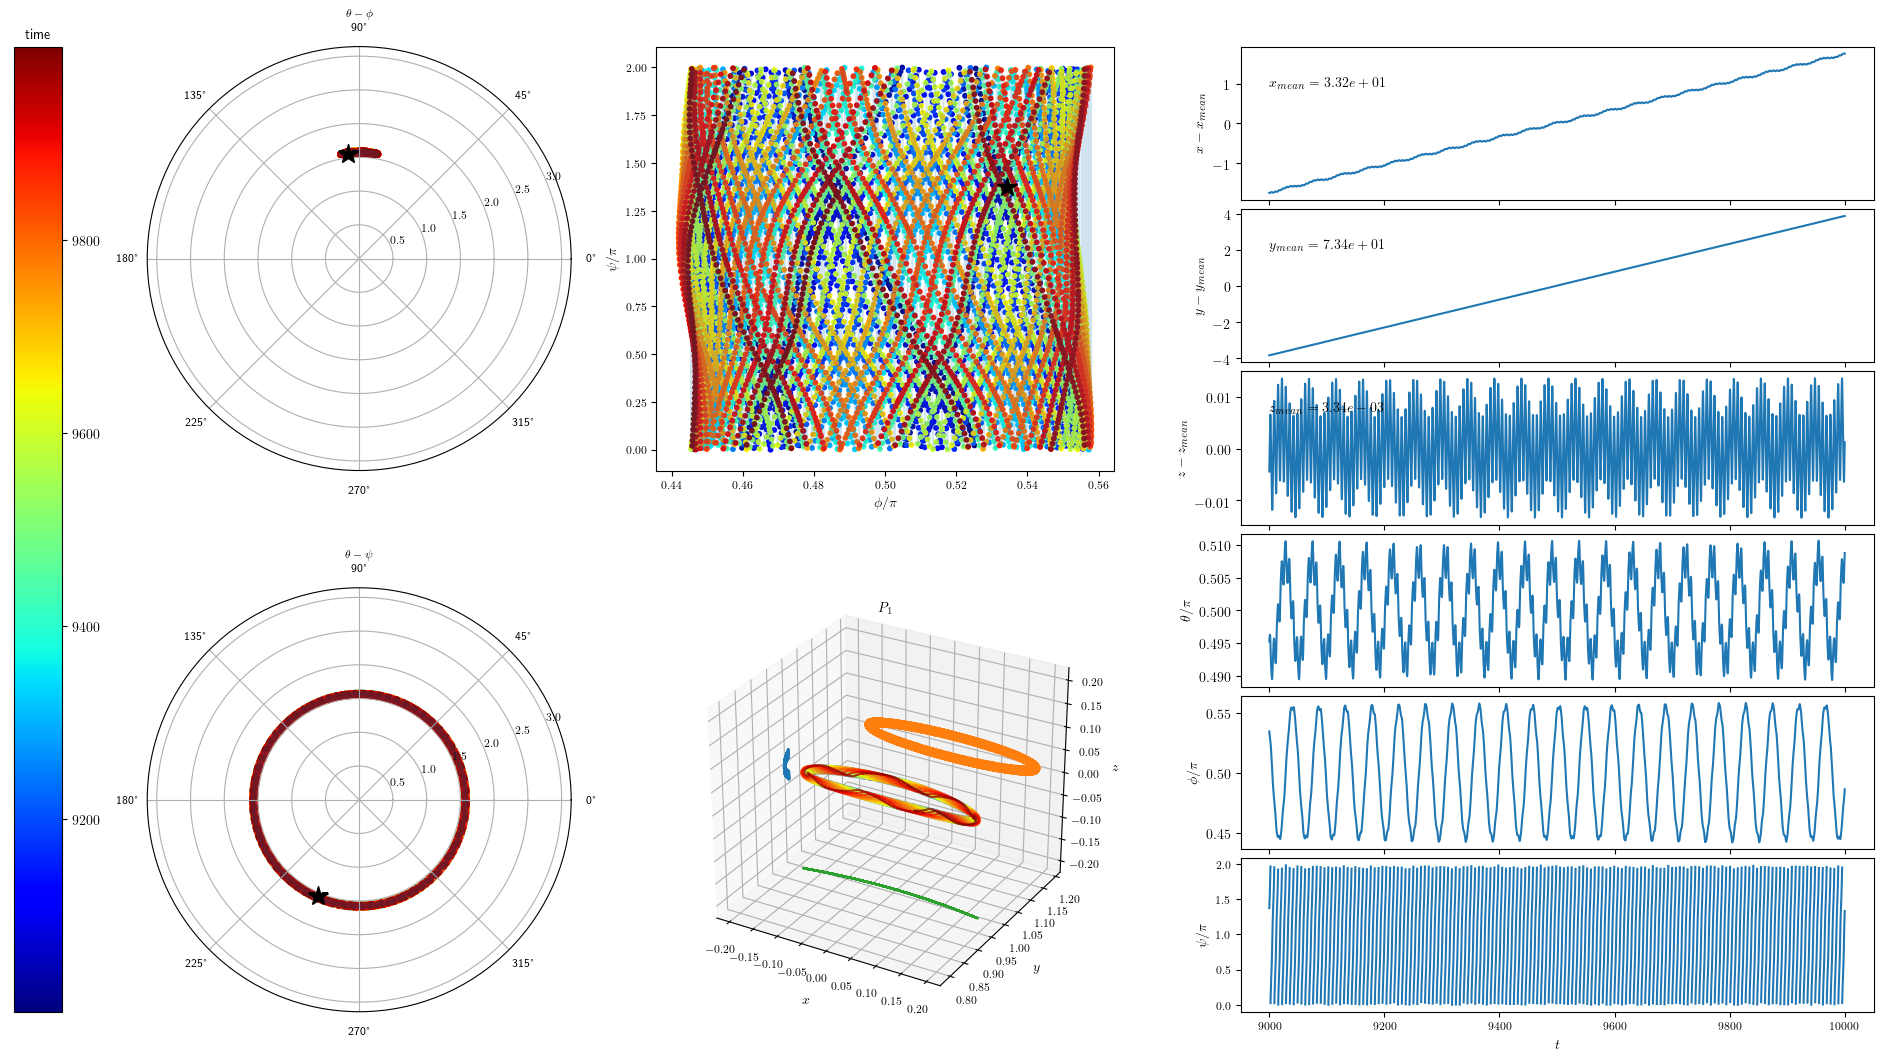

In [11]:
tidx = np.isclose(case_idx, 2)
tpath = pickle_path_list[tidx][0]

with open(tpath, 'rb') as handle:
    tpick = pickle.load(handle)
Table_t = tpick['Table_t']
Table_dt = tpick['Table_dt']
Table_X = tpick['Table_X']
Table_P = tpick['Table_P']
Table_P2 = tpick['Table_P2']
Table_theta = tpick['Table_theta']
Table_phi = tpick['Table_phi']
Table_psi = tpick['Table_psi']
Table_eta = tpick['Table_eta']
idx = Table_t > 9000
spf_tb.show_table_result_v2(Table_t[idx], Table_dt[idx], Table_X[idx], Table_P[idx], Table_P2[idx], 
                            Table_theta[idx], Table_phi[idx], Table_psi[idx], Table_eta[idx])

(array([ 266.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
       5156.]), array([ 1. ,  1.9,  2.8,  3.7,  4.6,  5.5,  6.4,  7.3,  8.2,  9.1, 10. ]), <a list of 10 Patch objects>)
(array([3683.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
       1739.]), array([ 1. ,  1.9,  2.8,  3.7,  4.6,  5.5,  6.4,  7.3,  8.2,  9.1, 10. ]), <a list of 10 Patch objects>)
(array([ 156.,  455.,  522.,    0., 1301.,    0.,    0.,    0.,    0.,
       2988.]), array([ 1. ,  1.9,  2.8,  3.7,  4.6,  5.5,  6.4,  7.3,  8.2,  9.1, 10. ]), <a list of 10 Patch objects>)
(array([   0.,    0.,    0.,    0.,    0., 5422.,    0.,    0.,    0.,
          0.]), array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5]), <a list of 10 Patch objects>)
5422, -0.0095, -0.0095, -0.0095±1.89e-14
5422, 4.0678e-04, -4.0678e-04, 1.9506e-06±4.07e-04
0.9926±0.0000, 0.000000


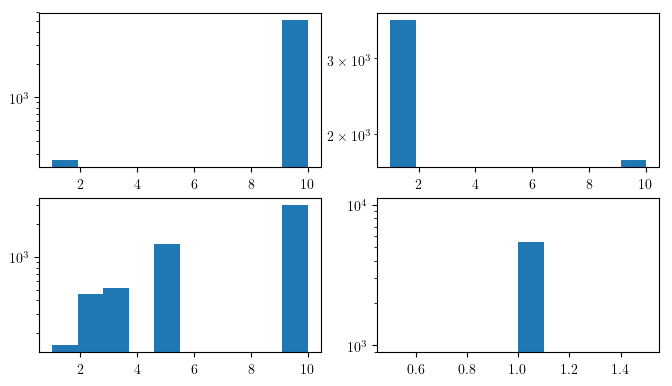

In [9]:
# tidx = np.isclose(case_idx, 0)
# tidx = np.isclose(case_idx, 2)
tidx = np.isclose(case_idx, 3)


figsize = np.array((16, 9)) * 0.5
dpi = 100
fig, axs = plt.subplots(2, 2, figsize=figsize, dpi=dpi)
for axi, use_autocorrelate_fre_list in zip(axs.ravel(), (theta_autocorrelate_fre_list, phi_autocorrelate_fre_list, 
                                                         psi_autocorrelate_fre_list, eta_autocorrelate_fre_list)):
    t1 = use_autocorrelate_fre_list[tidx][:, 0]
    t2 = use_autocorrelate_fre_list[tidx][:, 1][t1[:, 0] / t1[:, 1] > 1]
    print(axi.hist(t1[:, 0] / t1[:, 1], 10, log=True, ))
# print(plt.hist(dy_list[tidx], 10, log=True, ))
print('%d, %.4f, %.4f, %.4f±%.2e' % (tidx.sum(), dy_list[tidx].max(), dy_list[tidx].min(), 
                                      dy_list[tidx].mean(), dy_list[tidx].std()))
print('%d, %.4e, %.4e, %.4e±%.2e' % (tidx.sum(), dz_list[tidx].max(), dz_list[tidx].min(), 
                                      dz_list[tidx].mean(), dz_list[tidx].std()))
if t2.size > 0:
    tpct = (t2[:, 1] / t2[:, 0]).max()
else:
    tpct = 0
print('%.4f±%.4f, %f' % (np.mean(std_eta_list[tidx][:, 0] / np.pi), (std_eta_list[tidx][:, 1] / np.pi).max(), tpct))

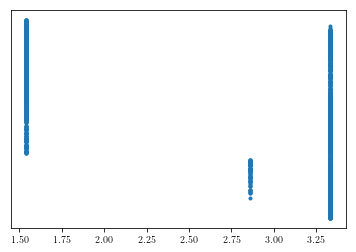

In [37]:
t1 = use_autocorrelate_fre_list[tidx][:, 0]
t2 = use_autocorrelate_fre_list[tidx][:, 1]
plt.semilogy(t1[:, 0] / t1[:, 1], t2[:, 1] / t2[:, 0], '.')

(array([ 879.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
       2012.]), array([1.        , 1.23333333, 1.46666667, 1.7       , 1.93333333,
       2.16666667, 2.4       , 2.63333333, 2.86666667, 3.1       ,
       3.33333333]), <a list of 10 Patch objects>)
2891, 0.0053, 0.0053, 0.0053±1.16e-06
0.7135±0.0985, 0.042171


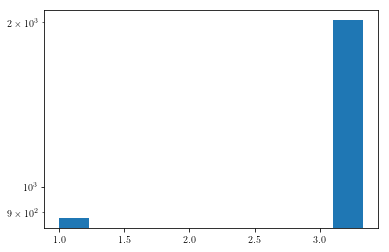

In [12]:
use_autocorrelate_fre_list = phi_autocorrelate_fre_list
# use_autocorrelate_fre_list = eta_autocorrelate_fre_list
# tidx = np.isclose(case_idx, 2)
# tidx = np.isclose(case_idx, 0)
tidx = np.isclose(case_idx, 3)

t1 = use_autocorrelate_fre_list[tidx][:, 0]
t2 = use_autocorrelate_fre_list[tidx][:, 1][t1[:, 0] / t1[:, 1] > 1]
print(plt.hist(t1[:, 0] / t1[:, 1], 10, log=True, ))
print('%d, %.4f, %.4f, %.4f±%.2e' % (tidx.sum(), dy_list[tidx].max(), dy_list[tidx].min(), 
                                      dy_list[tidx].mean(), dy_list[tidx].std()))
if t2.size > 0:
    tpct = (t2[:, 1] / t2[:, 0]).max()
else:
    tpct = 0
print('%.4f±%.4f, %f' % (np.mean(std_eta_list[tidx][:, 0] / np.pi), (std_eta_list[tidx][:, 1] / np.pi).max(), tpct))

(array([  10.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1880.]),
 array([0.01511773, 0.11007511, 0.20503249, 0.29998986, 0.39494724,
        0.48990462, 0.584862  , 0.67981938, 0.77477676, 0.86973414,
        0.96469152]),
 <a list of 10 Patch objects>)

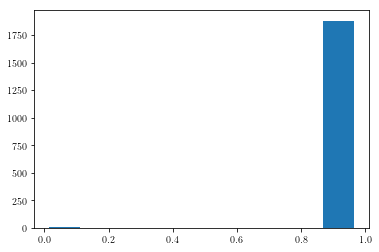

In [48]:
use_case = 5
tidx = np.isclose(case_idx, use_case)
plt.hist(std_eta_list[tidx][:, 0] / np.pi)

In [58]:
dy_list.max()

0.006499517236414144

In [86]:
t1 = psi_autocorrelate_fre_list[std_eta_list[:, 0] > np.pi * 0.8][:, 0]
t2 = psi_autocorrelate_fre_list[std_eta_list[:, 0] > np.pi * 0.8][:, 1]
t1

array([[0.05998978, 0.01999659],
       [0.0599785 , 0.01999283],
       [0.0600111 , 0.0200037 ],
       ...,
       [0.05998499, 0.019995  ],
       [0.05998398, 0.01799519],
       [0.06398384, 0.06398384]])